<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Check-your-sample-table-(i.e.-metadata-file)" data-toc-modified-id="Check-your-sample-table-(i.e.-metadata-file)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Check your sample table (i.e. metadata file)</a></span></li><li><span><a href="#Check-your-TRN" data-toc-modified-id="Check-your-TRN-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check your TRN</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load the data</a></span></li></ul></li><li><span><a href="#Regulatory-iModulons" data-toc-modified-id="Regulatory-iModulons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regulatory iModulons</a></span></li><li><span><a href="#Check-for-single-gene-iModulons" data-toc-modified-id="Check-for-single-gene-iModulons-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check for single gene iModulons</a></span></li><li><span><a href="#Explained-Variance" data-toc-modified-id="Explained-Variance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Explained Variance</a></span></li><li><span><a href="#iModulon-Size" data-toc-modified-id="iModulon-Size-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>iModulon Size</a></span></li><li><span><a href="#Save-iModulon-object" data-toc-modified-id="Save-iModulon-object-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save iModulon object</a></span></li></ul></div>

# Setup
This IPython notebook will walk through the steps of characterizing iModulons through semi-automated tools. You will need:
* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [1]:
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.util import explained_variance
from os import path
import pandas as pd
import re
from tqdm.notebook import tqdm

In [2]:
# Enter the location of your data here
data_dir = '../data/precise1k/'

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [3]:
df_metadata = pd.read_csv(path.join(data_dir,'metadata_qc.csv'),index_col=0)
df_metadata[['project','condition']].head()

,project,condition
ecoli_00001,control,wt_glc
ecoli_00002,control,wt_glc
ecoli_00003,fur,wt_dpd
ecoli_00004,fur,wt_dpd
ecoli_00005,fur,wt_fe


In [4]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [5]:
df_trn = pd.read_csv(path.join(data_dir,'TRN.csv'))
df_trn.head()

,regulator,gene_name,gene_id,effect,evidence,source
0,AccB,accB,b3255,-,0.0,RegulonDB_TF
1,RpoD,pheU,b4134,+,0.0,RegulonDB_sigma
2,RpoD,pheP,b0576,+,0.0,RegulonDB_sigma
3,RpoD,pheL,b2598,+,0.0,RegulonDB_sigma
4,RpoD,pheA,b2599,+,0.0,RegulonDB_sigma


The `regulator` and `gene_id` must be filled in for each row

In [6]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object!

In [7]:
ica_data = IcaData(
    M=path.join(data_dir,'M.csv'),
    A=path.join(data_dir,'A.csv'),
    X=path.join(data_dir,'log_tpm_norm_qc.csv'),
    gene_table=path.join(data_dir,'gene_info.csv'),
    sample_table=path.join(data_dir,'metadata_qc.csv'),
    trn=path.join(data_dir,'TRN.csv'),
    log_tpm=path.join(data_dir, 'log_tpm_qc.csv'),
    optimize_cutoff=True
)

# Regulatory iModulons
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

For this automated step, use strict cutoff for evidence required (can loosen later during manual annotation)

In [8]:
ica_data.compute_trn_enrichment(max_regs=2, evidence=[1, 2], save=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,PhoB-1,PhoB/RcsB-BglJ,2.674330e-18,9.605658e-14,1.000000,0.176471,0.300000,9.0,51.0,9.0,2.0
1,PhoB-1,LeuO/PhoB,1.299505e-17,2.333781e-13,1.000000,0.150000,0.260870,9.0,60.0,9.0,2.0
2,PhoB-1,PhoB,1.152220e-15,1.379515e-11,0.888889,0.170213,0.285714,8.0,47.0,9.0,1.0
3,PhoB-1,PhoB/Fis,7.859389e-15,7.057339e-11,1.000000,0.076271,0.141732,9.0,118.0,9.0,2.0
4,PhoB-1,IHF+PhoB,1.144609e-14,8.222416e-11,0.555556,1.000000,0.714286,5.0,5.0,9.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
1115,PspF,CpxR/PspF,4.207558e-12,5.037148e-08,1.000000,0.107143,0.193548,6.0,56.0,6.0,2.0
1116,PspF,IHF+PspF,5.730405e-12,5.145187e-08,0.666667,0.800000,0.727273,4.0,5.0,6.0,2.0
1117,ComR/MarR,ComR/MarR,1.605124e-11,5.765605e-07,0.400000,1.000000,0.571429,4.0,4.0,10.0,2.0
1118,262,BetI/YieP,1.372171e-13,4.928013e-09,0.833333,0.500000,0.625000,5.0,10.0,6.0,2.0


# Check for single gene iModulons

In [9]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)

In [10]:
for sg_mod in sg_imods:
    sg_name = ica_data.view_imodulon(sg_mod).sort_values(
        by='gene_weight', ascending=False).iloc[0, :]['gene_name']
    ica_data.rename_imodulons({sg_mod:f'SG_{sg_name}'})

In [11]:
ica_data.imodulon_names[:5]

['UC-1', 'SG_yqfG', 'SG_ythA', 'PhoB-1', 'BluR']

# iModulon Names

Convenient to string-ify all names so as not to have a mix of strings and ints in the index

In [12]:
rename_dict = {}
for im_name in ica_data.imodulon_names:
    if isinstance(im_name, int):
        rename_dict[im_name] = str(im_name)
ica_data.rename_imodulons(rename_dict)

# Compare PRECISE 2.0

In [7]:
precise2 = load_json_model('../data/precise2/precise2.json.gz')

In [8]:
precise1k = load_json_model('../data/precise1k/precise1k.json.gz')

In [20]:
precise2.M.shape[1] - 264

-46

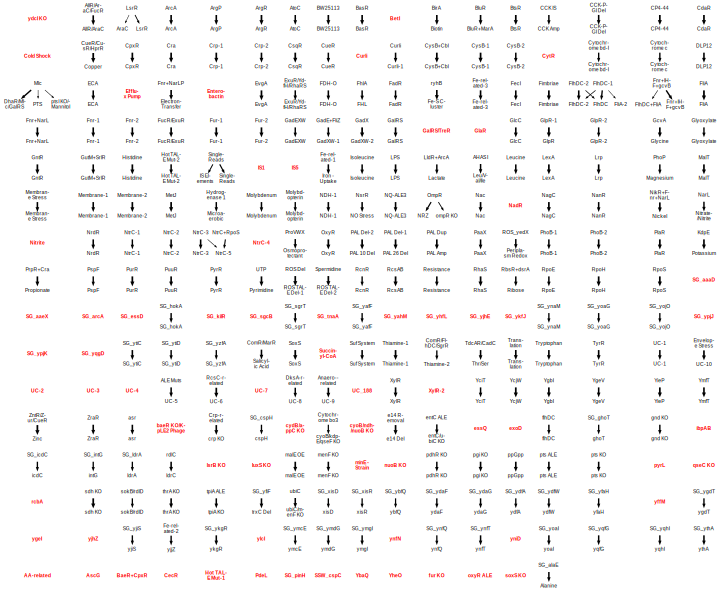

In [17]:
im_matches, dot = compare_ica(precise2.M, precise1k.M, cutoff=0.25, show_all=True)
dot

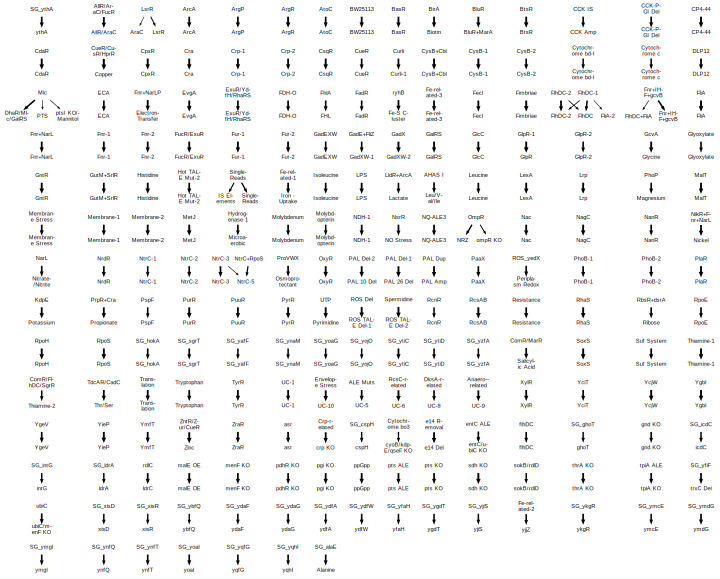

In [10]:
dot

In [14]:
im_matches, dot = compare_ica(ica_data.M, precise2.M, cutoff=0.25)

In [15]:
new_p1k_im_rows = []
p2_rename_dict = {}
for p1k_im in ica_data.imodulon_table.index:
    im_match = [match for match in im_matches if match[0] == p1k_im]
    # could be multiple matches, or zero - only want to update if we have one match
    if len(im_match) == 1:
        p2_im = im_match[0][1]
        p2_rename_dict[p1k_im] = p2_im
        new_p1k_im_rows.append({
            'enrichment_category': precise2.imodulon_table.loc[p2_im]['enrichment_category'],
            'system_category': precise2.imodulon_table.loc[p2_im]['system_category'],
            'functional_category': precise2.imodulon_table.loc[p2_im]['functional_category'],
            'PRECISE 2.0': p2_im,
            'P2.0_corr': im_match[0][2]
        })
    else:
        new_p1k_im_rows.append({
            'enrichment_category': None,
            'system_category': None,
            'functional_category': None,
            'PRECISE 2.0': None,
            'P2.0_corr': None
        })

In [16]:
ica_data.rename_imodulons(p2_rename_dict)

In [17]:
new_row_df = pd.DataFrame(new_p1k_im_rows, index=ica_data.imodulon_table.index)
ica_data.imodulon_table = ica_data.imodulon_table.merge(new_row_df, left_index=True, right_index=True)

# Explained Variance

In [18]:
exp_vars = [explained_variance(ica_data, imodulons=[imod]) for imod in ica_data.imodulon_names]

In [19]:
ica_data.imodulon_table['exp_var'] = exp_vars

# iModulon Size

In [20]:
ica_data.imodulon_table['imodulon_size'] = [ica_data.view_imodulon(imod).shape[0]
                                            for imod in ica_data.imodulon_names]

# Re-save individual data files with new naming

In [21]:
ica_data.imodulon_table.to_csv('../data/precise1k/imodulon_table.csv')
ica_data.A.to_csv('../data/precise1k/A.csv')
ica_data.M.to_csv('../data/precise1k/M.csv')

# Save iModulon object

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [22]:
save_to_json(ica_data,'../data/precise1k/precise1k', compress=True)